In [1]:
from model import deepaxon_plusplus_model
from model import deepaxon_model
from keras.utils import normalize
from keras.utils import to_categorical
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [2]:
#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=3 #Number of classes for segmentation

In [3]:
dir_path = 'test'
image_patch_path = os.path.join(dir_path, 'images', 'cropped', 'patches')
mask_patch_path = os.path.join(dir_path, 'masks', 'cropped', 'patches')

In [4]:
def get_images(patch_path):
    img_array = []
    for image_name in sorted(os.listdir(patch_path)):
        image_path = os.path.join(patch_path, image_name)
        img = cv2.imread(image_path, 0)
        img_array.append(img)
    return np.array(img_array)

In [5]:
train_images = get_images(image_patch_path)
train_masks = get_images(mask_patch_path)

In [6]:
label_encoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_flat = train_masks.reshape(-1, 1)
train_masks_flat_encoded = label_encoder.fit_transform(train_masks_flat)
train_masks_encoded = train_masks_flat_encoded.reshape(n, h, w)

c:\Users\kushs\miniconda3\envs\da_venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
np.unique(train_masks_encoded)

array([0, 1, 2], dtype=int64)

In [8]:
train_images = normalize(train_images, axis=1)
train_images = np.expand_dims(train_images, axis=3)
train_masks = np.expand_dims(train_masks_encoded, axis=3)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size = 0.30, random_state = 0)

In [10]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [11]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [12]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_masks_flat_encoded),
                                                  y=train_masks_flat_encoded)
print("Class weights are...:", class_weights)

Class weights are...: [1.10231669 0.84575233 1.09836948]


In [13]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [14]:
def get_model():
    return deepaxon_plusplus_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=3)

In [15]:
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [16]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)

Epoch 1/50
2/2 [==============================] - 16s 4s/step - loss: 1.0972 - accuracy: 0.3540 - val_loss: 1.0893 - val_accuracy: 0.4034
Epoch 2/50
2/2 [==============================] - 12s 4s/step - loss: 1.1044 - accuracy: 0.3999 - val_loss: 1.0894 - val_accuracy: 0.5115
Epoch 3/50
2/2 [==============================] - 12s 4s/step - loss: 1.0886 - accuracy: 0.4538 - val_loss: 1.0830 - val_accuracy: 0.5037
Epoch 4/50
2/2 [==============================] - 12s 4s/step - loss: 1.0812 - accuracy: 0.4283 - val_loss: 1.0726 - val_accuracy: 0.6485
Epoch 5/50
2/2 [==============================] - 12s 4s/step - loss: 1.0639 - accuracy: 0.5256 - val_loss: 1.0338 - val_accuracy: 0.5837
Epoch 6/50
2/2 [==============================] - 12s 4s/step - loss: 1.0422 - accuracy: 0.4625 - val_loss: 1.0299 - val_accuracy: 0.5514
Epoch 7/50
2/2 [==============================] - 12s 4s/step - loss: 1.0113 - accuracy: 0.5392 - val_loss: 0.9967 - val_accuracy: 0.5495
Epoch 8/50
2/2 [==================

In [17]:
model.save(r"D:\Research\Isaacs Lab\DeepAxon\test\model2.keras")

In [18]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

1/1 [==============================] - 2s 2s/step - loss: 0.4355 - accuracy: 0.8180
Accuracy is =  81.79610967636108 %


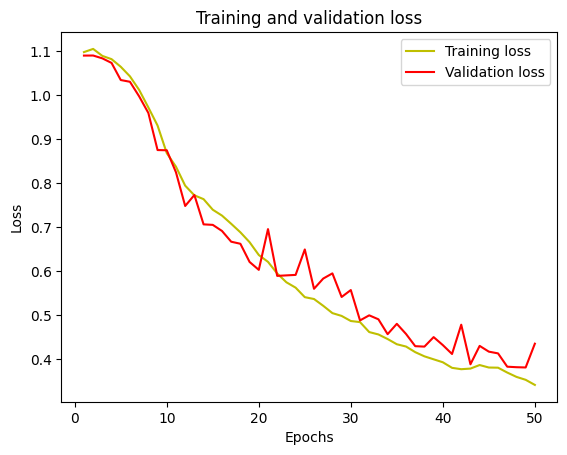

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

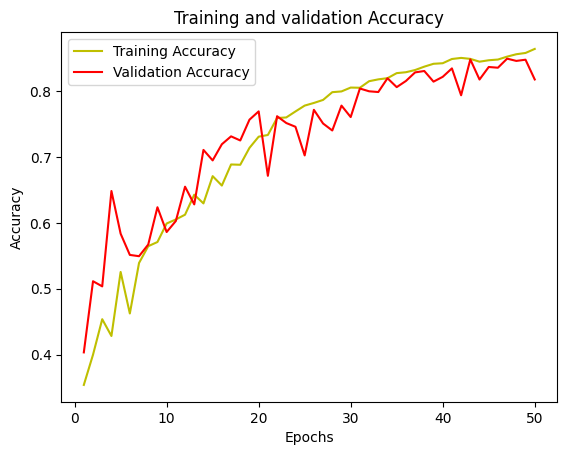

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
model.load_weights(r"D:\Research\Isaacs Lab\DeepAxon\test\model2.keras")

In [22]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 [==============================] - 2s 2s/step


In [23]:
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.6977257


In [24]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)

[[178469.  12337.   1648.      0.]
 [ 57034. 195680.   8849.      0.]
 [ 26756.  12677. 161910.      0.]
 [     0.      0.      0.      0.]]
IoU for class1 is:  0.64605564
IoU for class2 is:  0.68281823
IoU for class3 is:  0.76430327


In [25]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 326ms/step


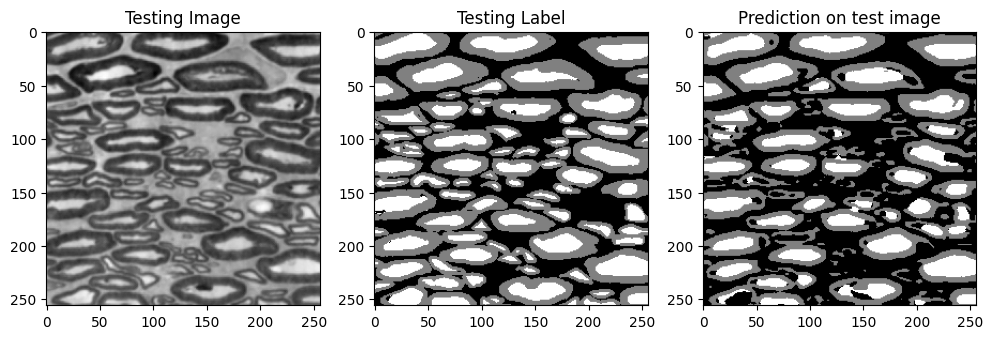

In [26]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()